<a href="https://colab.research.google.com/github/Deeksha-HL/Fcae-Detection-processing/blob/main/KYC_Face_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# Install MTCNN (face detection) and other required packages
!pip install -q mtcnn tensorflow opencv-python scikit-learn tqdm

import cv2, numpy as np, pandas as pd, os, json, shutil
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings; warnings.filterwarnings('ignore')

from mtcnn import MTCNN
import tensorflow as tf

print('=' * 55)
print('  ✅  All packages installed successfully!')
print('=' * 55)
print(f'  OpenCV     : {cv2.__version__}')
print(f'  TensorFlow : {tf.__version__}')
print(f'  NumPy      : {np.__version__}')


  ✅  All packages installed successfully!
  OpenCV     : 4.13.0
  TensorFlow : 2.19.0
  NumPy      : 2.0.2


In [33]:
from google.colab import drive
drive.mount('/content/drive')

# ── Locate the DATASET folder ──────────────────────────────────────────────
DRIVE_DATASET = '/content/drive/MyDrive/Face Dataset'
OUTPUT_DIR    = '/content/drive/MyDrive/Face Dataset/Processed Output'

assert os.path.exists(DRIVE_DATASET), (
    f'❌  Folder not found: {DRIVE_DATASET}\n'
    '    Make sure your Drive folder is named exactly  DATASET')

print(f'✅  Drive mounted')
print(f'📂  Dataset path : {DRIVE_DATASET}')
print(f'📂  Output path  : {OUTPUT_DIR}')
print()
print('📋  Files found inside DATASET:')
for entry in sorted(os.scandir(DRIVE_DATASET), key=lambda e: e.name)[:20]:
    tag = '📁' if entry.is_dir() else '📄'
    print(f'   {tag}  {entry.name}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅  Drive mounted
📂  Dataset path : /content/drive/MyDrive/Face Dataset
📂  Output path  : /content/drive/MyDrive/Face Dataset/Processed Output

📋  Files found inside DATASET:
   📁  AxonLabs_Diverse Selfie & ID Photo Dataset - samples
   📁  Processed Output
   📁  Selfie & id data - public sample
   📄  metadata_images.csv


In [34]:
# ╔══════════════════════════════════════════════════╗
# ║            C O N F I G U R A T I O N             ║
# ╚══════════════════════════════════════════════════╝

class Config:
    # ── Paths ────────────────────────────────────────
    DATA_DIR   = DRIVE_DATASET          # source images
    OUTPUT_DIR = OUTPUT_DIR             # save results here

    # ── Image ────────────────────────────────────────
    IMG_SIZE   = (224, 224)             # (width, height)

    # ── Face detection ───────────────────────────────
    USE_MTCNN      = True               # True=MTCNN, False=Haar only
    MIN_CONFIDENCE = 0.90               # lower → more detections
    FACE_MARGIN    = 20                 # pixels of context around face

    # ── Splits ───────────────────────────────────────
    TRAIN_RATIO = 0.70
    VAL_RATIO   = 0.15
    TEST_RATIO  = 0.15                  # must sum to 1.0

    # ── Augmentation ─────────────────────────────────
    AUGMENT_TRAIN    = True
    NUM_AUGMENTATIONS = 2               # extra copies per train image

cfg = Config()

# Create output sub-folders
for split in ['train/selfies','train/ids',
              'val/selfies',  'val/ids',
              'test/selfies', 'test/ids']:
    Path(f'{cfg.OUTPUT_DIR}/{split}').mkdir(parents=True, exist_ok=True)

print('✅  Configuration ready')
print(f'   IMG_SIZE        = {cfg.IMG_SIZE}')
print(f'   MIN_CONFIDENCE  = {cfg.MIN_CONFIDENCE}')
print(f'   FACE_MARGIN     = {cfg.FACE_MARGIN}')
print(f'   Split           = {cfg.TRAIN_RATIO}/{cfg.VAL_RATIO}/{cfg.TEST_RATIO}')
print(f'   Augmentations   = {cfg.NUM_AUGMENTATIONS} extra per train image')


✅  Configuration ready
   IMG_SIZE        = (224, 224)
   MIN_CONFIDENCE  = 0.9
   FACE_MARGIN     = 20
   Split           = 0.7/0.15/0.15
   Augmentations   = 2 extra per train image


In [35]:
# ══════════════════════════════════════════════════════════════════
#  STEP 1 — FACE DETECTION
# ══════════════════════════════════════════════════════════════════

class FaceDetector:
    """MTCNN detector with Haar Cascade fallback."""

    def __init__(self):
        if cfg.USE_MTCNN:
            try:
                self.mtcnn = MTCNN()
                self._mode = 'mtcnn'
                print('  ✅  FaceDetector  →  MTCNN loaded')
            except Exception as e:
                print(f'  ⚠️   MTCNN failed ({e}), falling back to Haar')
                self._mode = 'haar'
        else:
            self._mode = 'haar'

        if self._mode == 'haar':
            xml = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
            self.haar = cv2.CascadeClassifier(xml)
            print('  ✅  FaceDetector  →  Haar Cascade loaded')

    def detect(self, img_rgb):
        """Return (x,y,w,h), landmarks_dict or None, None."""
        if self._mode == 'mtcnn':
            return self._mtcnn_detect(img_rgb)
        return self._haar_detect(img_rgb), None

    def _mtcnn_detect(self, img_rgb):
        results = self.mtcnn.detect_faces(img_rgb)
        if not results:
            return None, None
        best = max(results, key=lambda r: r['confidence'])
        if best['confidence'] < cfg.MIN_CONFIDENCE:
            return None, None
        x, y, w, h = best['box']
        x, y = max(0, x), max(0, y)       # clamp negatives
        return (x, y, w, h), best['keypoints']

    def _haar_detect(self, img_rgb):
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        faces = self.haar.detectMultiScale(gray, 1.1, 5, minSize=(60, 60))
        if len(faces) == 0:
            return None
        return tuple(max(faces, key=lambda f: f[2] * f[3]))


# ══════════════════════════════════════════════════════════════════
#  STEP 2 — FACE CROPPING
# ══════════════════════════════════════════════════════════════════

class FaceCropper:
    """Crop the face bounding box + margin from the image."""

    @staticmethod
    def crop(img, bbox):
        x, y, w, h = bbox
        m = cfg.FACE_MARGIN
        H, W = img.shape[:2]
        x1 = max(0, x - m)
        y1 = max(0, y - m)
        x2 = min(W, x + w + m)
        y2 = min(H, y + h + m)
        cropped = img[y1:y2, x1:x2]
        if cropped.size == 0:
            return None
        return cropped


# ══════════════════════════════════════════════════════════════════
#  STEP 3 — FACE ALIGNMENT
# ══════════════════════════════════════════════════════════════════

class FaceAligner:
    """Rotate face so the eye line is horizontal."""

    @staticmethod
    def align(img, landmarks):
        if landmarks is None:
            return img
        try:
            le = landmarks['left_eye']
            re = landmarks['right_eye']
            angle = np.degrees(np.arctan2(re[1] - le[1], re[0] - le[0]))
            cx = (le[0] + re[0]) // 2
            cy = (le[1] + re[1]) // 2
            H, W = img.shape[:2]
            M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
            return cv2.warpAffine(img, M, (W, H), flags=cv2.INTER_CUBIC,
                                  borderMode=cv2.BORDER_REFLECT)
        except Exception:
            return img


# ══════════════════════════════════════════════════════════════════
#  STEP 4 — NORMALISATION
# ══════════════════════════════════════════════════════════════════

class Normalizer:
    """Resize → CLAHE contrast enhancement → scale to [0,1]."""

    _clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    @classmethod
    def normalize(cls, img_bgr):
        # 1. Resize
        img = cv2.resize(img_bgr, cfg.IMG_SIZE, interpolation=cv2.INTER_AREA)
        # 2. CLAHE on L-channel of LAB
        lab        = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b    = cv2.split(lab)
        l          = cls._clahe.apply(l)
        img        = cv2.cvtColor(cv2.merge([l, a, b]), cv2.COLOR_LAB2BGR)
        # 3. Convert BGR → RGB and scale to float [0,1]
        img_rgb    = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img_rgb.astype(np.float32) / 255.0


# ══════════════════════════════════════════════════════════════════
#  STEP 5 — DATA AUGMENTATION
# ══════════════════════════════════════════════════════════════════

class Augmentor:
    """Random brightness · horizontal flip · rotation · noise."""

    @staticmethod
    def augment(img_float):
        """Input/output: float32 [0,1] RGB, shape (H,W,3)."""
        img = (img_float * 255).astype(np.uint8)

        # Brightness
        if np.random.rand() > 0.5:
            delta = np.random.randint(-40, 40)
            hsv       = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.int16)
            hsv[...,2] = np.clip(hsv[...,2] + delta, 0, 255)
            img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

        # Horizontal flip
        if np.random.rand() > 0.5:
            img = cv2.flip(img, 1)

        # Small rotation
        if np.random.rand() > 0.5:
            angle = np.random.uniform(-12, 12)
            H, W  = img.shape[:2]
            M     = cv2.getRotationMatrix2D((W/2, H/2), angle, 1.0)
            img   = cv2.warpAffine(img, M, (W, H),
                                   borderMode=cv2.BORDER_REFLECT)

        # Gaussian noise
        if np.random.rand() > 0.6:
            noise = np.random.normal(0, 6, img.shape).astype(np.int16)
            img   = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)

        return img.astype(np.float32) / 255.0


print('✅  All preprocessing classes defined')
print('   FaceDetector  | FaceCropper | FaceAligner | Normalizer | Augmentor')


✅  All preprocessing classes defined
   FaceDetector  | FaceCropper | FaceAligner | Normalizer | Augmentor


In [36]:
from collections import defaultdict

EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}

def scan_images(root):
    """Return all image paths under root."""
    found = []
    for p in Path(root).rglob('*'):
        if p.suffix.lower() in EXTS:
            found.append(p)
    return found

def build_pairs(images):
    """Group images into (selfie, id_photo) pairs by person folder."""
    buckets = defaultdict(lambda: {'selfie': None, 'id': None})
    for p in images:
        name   = p.stem.lower()
        parent = p.parent.name.lower()
        pid    = p.parent.name          # person / group identifier
        if any(k in name or k in parent for k in ('selfie', 'live', 'real')):
            buckets[pid]['selfie'] = str(p)
        elif any(k in name or k in parent for k in ('id','official','card','doc')):
            buckets[pid]['id'] = str(p)
        else:
            # If structure is unknown, treat first two images per folder as pair
            if buckets[pid]['selfie'] is None:
                buckets[pid]['selfie'] = str(p)
            elif buckets[pid]['id'] is None:
                buckets[pid]['id'] = str(p)

    pairs = []
    for pid, imgs in buckets.items():
        if imgs['selfie'] and imgs['id']:
            pairs.append({'person_id': pid,
                          'selfie_path': imgs['selfie'],
                          'id_path':     imgs['id'],
                          'label': 1})
    return pd.DataFrame(pairs)

# ── Scan ────────────────────────────────────────────────────────────────────
print('🔍  Scanning DATASET folder ...')
all_imgs = scan_images(cfg.DATA_DIR)
print(f'   Total images found : {len(all_imgs)}')

df = build_pairs(all_imgs)
print(f'   Selfie-ID pairs    : {len(df)}')

if len(df) == 0:
    print()
    print('❌  No pairs were built.')
    print('   Check that your DATASET folder contains images and')
    print('   that sub-folder or file names include keywords like')
    print('   selfie / id / official / card.')
else:
    print()
    print('📋  Sample pairs:')
    display(df.head(5))


🔍  Scanning DATASET folder ...
   Total images found : 315
   Selfie-ID pairs    : 19

📋  Sample pairs:


,person_id,selfie_path,id_path,label
0,Processed Output,/content/drive/MyDrive/Face Dataset/Processed ...,/content/drive/MyDrive/Face Dataset/Processed ...,1
1,Caucasian_female_53,/content/drive/MyDrive/Face Dataset/AxonLabs_D...,/content/drive/MyDrive/Face Dataset/AxonLabs_D...,1
2,Caucasian_male_37,/content/drive/MyDrive/Face Dataset/AxonLabs_D...,/content/drive/MyDrive/Face Dataset/AxonLabs_D...,1
3,Caucasian_male_36,/content/drive/MyDrive/Face Dataset/AxonLabs_D...,/content/drive/MyDrive/Face Dataset/AxonLabs_D...,1
4,Caucasian_female_47,/content/drive/MyDrive/Face Dataset/AxonLabs_D...,/content/drive/MyDrive/Face Dataset/AxonLabs_D...,1


In [37]:
np.random.seed(42)

train_df, temp_df = train_test_split(
    df,
    test_size = cfg.VAL_RATIO + cfg.TEST_RATIO,
    random_state=42
)
val_df, test_df = train_test_split(
    temp_df,
    test_size = cfg.TEST_RATIO / (cfg.VAL_RATIO + cfg.TEST_RATIO),
    random_state=42
)

print('✅  Split complete')
print(f'   Train : {len(train_df):>5} pairs  ({cfg.TRAIN_RATIO*100:.0f}%)')
print(f'   Val   : {len(val_df):>5} pairs  ({cfg.VAL_RATIO*100:.0f}%)')
print(f'   Test  : {len(test_df):>5} pairs  ({cfg.TEST_RATIO*100:.0f}%)')

# Save CSV metadata
train_df.reset_index(drop=True).to_csv(f'{cfg.OUTPUT_DIR}/train_metadata.csv', index=False)
val_df.reset_index(drop=True).to_csv(f'{cfg.OUTPUT_DIR}/val_metadata.csv',   index=False)
test_df.reset_index(drop=True).to_csv(f'{cfg.OUTPUT_DIR}/test_metadata.csv', index=False)
print('\n📄  Metadata CSVs saved to Drive')


✅  Split complete
   Train :    13 pairs  (70%)
   Val   :     3 pairs  (15%)
   Test  :     3 pairs  (15%)

📄  Metadata CSVs saved to Drive


In [38]:
# Initialise processors
detector  = FaceDetector()
cropper   = FaceCropper()
aligner   = FaceAligner()
normalizer= Normalizer()
augmentor = Augmentor()

def preprocess_one(image_path):
    """
    Full pipeline for a single image.
    Returns (face_float32, detection_method) or (None, error_reason).
    """
    # Load
    img_bgr = cv2.imread(str(image_path))
    if img_bgr is None:
        return None, 'load_failed'
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # STEP 1 — Detect
    bbox, landmarks = detector.detect(img_rgb)
    if bbox is None:
        return None, 'no_face'

    # STEP 2 — Crop
    face_bgr = cropper.crop(img_bgr, bbox)
    if face_bgr is None:
        return None, 'crop_failed'

    # STEP 3 — Align  (convert to RGB for landmark coords)
    face_rgb = cv2.cvtColor(face_bgr, cv2.COLOR_BGR2RGB)
    face_bgr = cv2.cvtColor(
        aligner.align(face_rgb, landmarks), cv2.COLOR_RGB2BGR)

    # STEP 4 — Normalise
    face_norm = normalizer.normalize(face_bgr)
    return face_norm, 'ok'


def process_split(split_df, split_name, augment=False):
    """Process one split and save .npy files to Drive."""
    selfie_dir = Path(f'{cfg.OUTPUT_DIR}/{split_name}/selfies')
    id_dir     = Path(f'{cfg.OUTPUT_DIR}/{split_name}/ids')
    stats = dict(total=len(split_df), ok=0, no_face=0, failed=0, augmented=0)

    for i, row in tqdm(split_df.iterrows(),
                       total=len(split_df),
                       desc=f'{split_name:5s}',
                       ncols=80):
        idx = split_df.index.get_loc(i)

        # --- selfie ---
        face, status = preprocess_one(row['selfie_path'])
        if face is not None:
            np.save(selfie_dir / f'{idx}_selfie.npy', face)
            stats['ok'] += 1
            if augment and cfg.AUGMENT_TRAIN:
                for k in range(cfg.NUM_AUGMENTATIONS):
                    np.save(selfie_dir / f'{idx}_selfie_aug{k}.npy',
                            augmentor.augment(face))
                    stats['augmented'] += 1
        else:
            stats['no_face' if status=='no_face' else 'failed'] += 1

        # --- id photo ---
        face_id, status_id = preprocess_one(row['id_path'])
        if face_id is not None:
            np.save(id_dir / f'{idx}_id.npy', face_id)
            stats['ok'] += 1
        else:
            stats['no_face' if status_id=='no_face' else 'failed'] += 1

    return stats


# ── Run all three splits ─────────────────────────────────────────────────────
print('='*55)
print('  🚀  PREPROCESSING STARTED')
print('='*55)

all_stats = {}
all_stats['train'] = process_split(train_df.reset_index(drop=True), 'train', augment=True)
all_stats['val']   = process_split(val_df.reset_index(drop=True),   'val',   augment=False)
all_stats['test']  = process_split(test_df.reset_index(drop=True),  'test',  augment=False)

# Save stats
with open(f'{cfg.OUTPUT_DIR}/preprocessing_stats.json', 'w') as f:
    json.dump(all_stats, f, indent=2)

print()
print('='*55)
print('  ✅  PREPROCESSING COMPLETE')
print('='*55)
for split, s in all_stats.items():
    rate = s['ok'] / max(s['total']*2, 1) * 100
    print(f'  {split.upper():5s}  total={s["total"]}  '
          f'ok={s["ok"]}  no_face={s["no_face"]}  '
          f'failed={s["failed"]}  aug={s["augmented"]}  '
          f'({rate:.1f}% success)')


  ✅  FaceDetector  →  MTCNN loaded
  🚀  PREPROCESSING STARTED


test : 100%|██████████████████████████████████████| 3/3 [00:06<00:00,  2.14s/it]


  ✅  PREPROCESSING COMPLETE
  TRAIN  total=13  ok=26  no_face=0  failed=0  aug=26  (100.0% success)
  VAL    total=3  ok=6  no_face=0  failed=0  aug=0  (100.0% success)
  TEST   total=3  ok=5  no_face=1  failed=0  aug=0  (83.3% success)


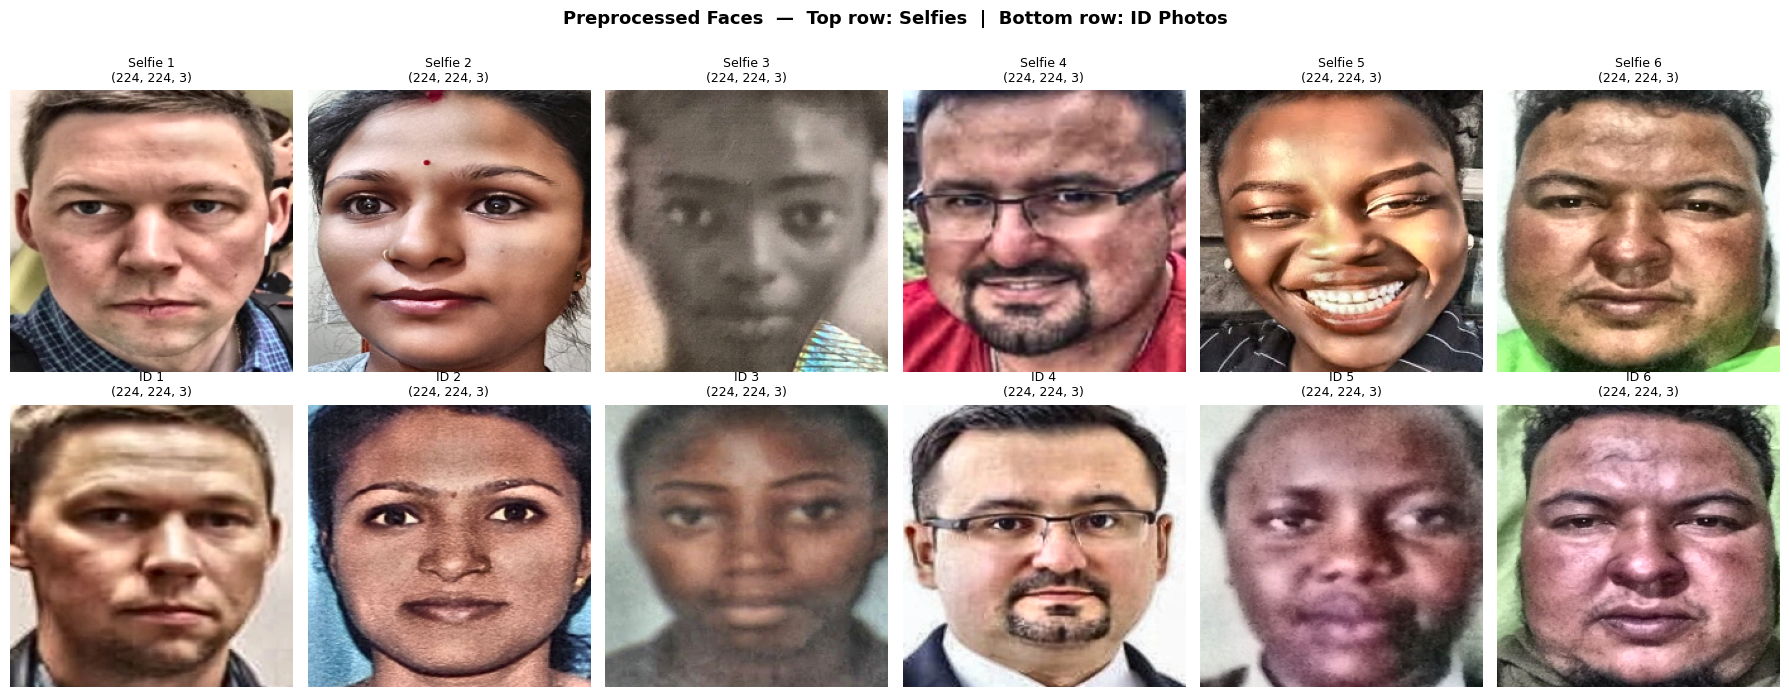


✅  Saved → /content/drive/MyDrive/Face Dataset/Processed Output/sample_faces.png


In [39]:
selfie_dir = Path(f'{cfg.OUTPUT_DIR}/train/selfies')
id_dir     = Path(f'{cfg.OUTPUT_DIR}/train/ids')

selfie_files = sorted(selfie_dir.glob('*_selfie.npy'))[:6]

if not selfie_files:
    print('⚠️   No preprocessed files found yet — run Cell 7 first.')
else:
    n = len(selfie_files)
    fig, axes = plt.subplots(2, n, figsize=(3*n, 7))
    fig.suptitle('Preprocessed Faces  —  Top row: Selfies  |  Bottom row: ID Photos',
                 fontsize=13, fontweight='bold', y=1.01)

    for col, sf in enumerate(selfie_files):
        stem  = sf.stem.replace('_selfie', '')
        id_f  = id_dir / f'{stem}_id.npy'

        # Selfie
        selfie = np.load(sf)
        axes[0, col].imshow(selfie)
        axes[0, col].set_title(f'Selfie {col+1}\n{selfie.shape}', fontsize=9)
        axes[0, col].axis('off')

        # ID photo
        if id_f.exists():
            id_img = np.load(id_f)
            axes[1, col].imshow(id_img)
            axes[1, col].set_title(f'ID {col+1}\n{id_img.shape}', fontsize=9)
        else:
            axes[1, col].text(0.5, 0.5, 'Not found', ha='center', va='center')
        axes[1, col].axis('off')

    plt.tight_layout()
    save_path = f'{cfg.OUTPUT_DIR}/sample_faces.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'\n✅  Saved → {save_path}')


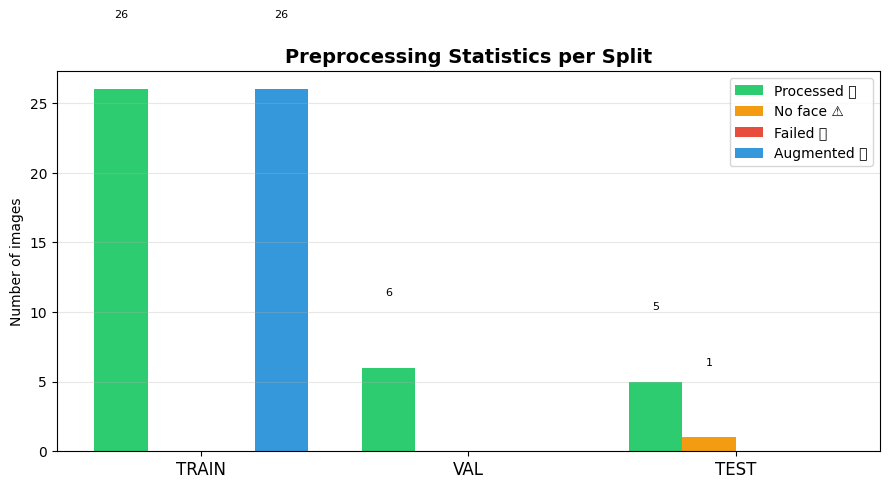


  PREPROCESSING QUALITY REPORT
  Overall success rate : 97.4%

  Split     Pairs     OK   NoFace   Failed    Aug    Rate
  ----------------------------------------------------
  TRAIN        13     26        0        0     26  100.0%
  VAL           3      6        0        0      0  100.0%
  TEST          3      5        1        0      0   83.3%

✅  Charts saved to Drive → /content/drive/MyDrive/Face Dataset/Processed Output


In [40]:
# Load stats
with open(f'{cfg.OUTPUT_DIR}/preprocessing_stats.json') as f:
    stats = json.load(f)

# ── Bar chart ────────────────────────────────────────────────────────────────
splits    = list(stats.keys())
ok_vals   = [s['ok']       for s in stats.values()]
nf_vals   = [s['no_face']  for s in stats.values()]
fail_vals = [s['failed']   for s in stats.values()]
aug_vals  = [s['augmented']for s in stats.values()]

x  = np.arange(len(splits))
w  = 0.2

fig, ax = plt.subplots(figsize=(9, 5))
b1 = ax.bar(x - 1.5*w, ok_vals,   w, label='Processed ✅', color='#2ecc71')
b2 = ax.bar(x - 0.5*w, nf_vals,   w, label='No face ⚠️',  color='#f39c12')
b3 = ax.bar(x + 0.5*w, fail_vals, w, label='Failed ❌',    color='#e74c3c')
b4 = ax.bar(x + 1.5*w, aug_vals,  w, label='Augmented ➕', color='#3498db')

for bars in [b1, b2, b3, b4]:
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            ax.text(bar.get_x() + bar.get_width()/2, h + 5,
                    str(int(h)), ha='center', va='bottom', fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels([s.upper() for s in splits], fontsize=12)
ax.set_ylabel('Number of images')
ax.set_title('Preprocessing Statistics per Split', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{cfg.OUTPUT_DIR}/stats_chart.png', dpi=150)
plt.show()

# ── Text summary ─────────────────────────────────────────────────────────────
print('\n' + '='*55)
print('  PREPROCESSING QUALITY REPORT')
print('='*55)
total_processed = sum(s['ok'] for s in stats.values())
total_images    = sum(s['total']*2 for s in stats.values())
print(f'  Overall success rate : {total_processed/total_images*100:.1f}%')
print()
print(f'  {"Split":<8} {"Pairs":>6} {"OK":>6} {"NoFace":>8} {"Failed":>8} {"Aug":>6} {"Rate":>7}')
print('  ' + '-'*52)
for split, s in stats.items():
    rate = s['ok'] / max(s['total']*2, 1) * 100
    print(f'  {split.upper():<8} {s["total"]:>6} {s["ok"]:>6} '
          f'{s["no_face"]:>8} {s["failed"]:>8} {s["augmented"]:>6} {rate:>6.1f}%')
print('='*55)
print(f'\n✅  Charts saved to Drive → {cfg.OUTPUT_DIR}')


In [41]:
selfie_dir = Path(f'{cfg.OUTPUT_DIR}/train/selfies')
id_dir     = Path(f'{cfg.OUTPUT_DIR}/train/ids')

# Load a mini-batch of 8
selfie_batch, id_batch, labels = [], [], []
meta = pd.read_csv(f'{cfg.OUTPUT_DIR}/train_metadata.csv')

for idx in range(min(8, len(meta))):
    sp = selfie_dir / f'{idx}_selfie.npy'
    ip = id_dir     / f'{idx}_id.npy'
    if sp.exists() and ip.exists():
        selfie_batch.append(np.load(sp))
        id_batch.append(np.load(ip))
        labels.append(int(meta.iloc[idx].get('label', 1)))

S = np.array(selfie_batch)
I = np.array(id_batch)
L = np.array(labels)

print('='*55)
print('  MODEL-READY VERIFICATION')
print('='*55)
print(f'  Selfie batch  shape : {S.shape}')
print(f'  ID     batch  shape : {I.shape}')
print(f'  Labels        shape : {L.shape}')
print(f'  Dtype               : {S.dtype}')
print(f'  Pixel range         : [{S.min():.3f},  {S.max():.3f}]')
print(f'  Expected shape      : (N, {cfg.IMG_SIZE[1]}, {cfg.IMG_SIZE[0]}, 3)')

ok = (S.shape[1:] == (cfg.IMG_SIZE[1], cfg.IMG_SIZE[0], 3)
      and S.dtype == np.float32
      and 0.0 <= S.min() and S.max() <= 1.0)

print()
if ok:
    print('  ✅  Data is correctly formatted for model training!')
else:
    print('  ⚠️   Shape or dtype mismatch — re-check configuration.')
print('='*55)

print()
print('📂  Output folder structure:')
for root, dirs, files in os.walk(cfg.OUTPUT_DIR):
    level = root.replace(cfg.OUTPUT_DIR, '').count(os.sep)
    indent = '   ' * level
    folder = os.path.basename(root)
    print(f'{indent}📁 {folder}/')
    if level < 2:
        sub = '   ' * (level + 1)
        for f in files[:4]:
            print(f'{sub}📄 {f}')
        if len(files) > 4:
            print(f'{sub}   ... and {len(files)-4} more')


  MODEL-READY VERIFICATION
  Selfie batch  shape : (8, 224, 224, 3)
  ID     batch  shape : (8, 224, 224, 3)
  Labels        shape : (8,)
  Dtype               : float32
  Pixel range         : [0.000,  1.000]
  Expected shape      : (N, 224, 224, 3)

  ✅  Data is correctly formatted for model training!

📂  Output folder structure:
📁 Processed Output/
   📄 train_metadata.csv
   📄 test_metadata.csv
   📄 val_metadata.csv
   📄 preprocessing_stats.json
      ... and 2 more
   📁 train/
      📁 selfies/
      📁 ids/
   📁 val/
      📁 selfies/
      📁 ids/
   📁 test/
      📁 selfies/
      📁 ids/


Face Veification


In [42]:
 !pip install keras-facenet

In [43]:
from keras_facenet import FaceNet
import numpy as np

embedder = FaceNet()
print("✅ FaceNet model loaded")

✅ FaceNet model loaded


In [44]:
def get_embedding(face_array):
    """
    Convert a preprocessed face image into a FaceNet embedding.

    Parameters:
        face_array (numpy.ndarray):
            Shape (224x224x3), dtype float32, values in [0,1]

    Returns:
        numpy.ndarray:
            512-dimensional embedding vector
    """
    # Add batch dimension (1, 224, 224, 3)
    face = np.expand_dims(face_array, axis=0)

    # Generate embedding
    embedding = embedder.embeddings(face)

    # Return flattened vector
    return embedding[0]

In [45]:
from pathlib import Path
import numpy as np

# Define training directories
selfie_dir = Path(f"{cfg.OUTPUT_DIR}/train/selfies")
id_dir     = Path(f"{cfg.OUTPUT_DIR}/train/ids")

# Get available selfie files
selfie_files = sorted(selfie_dir.glob("*_selfie.npy"))

if not selfie_files:
    print("⚠️ No preprocessed selfie files found. Run preprocessing first.")
else:
    # Pick first available sample
    sample_selfie_path = selfie_files[0]
    sample_id_path = id_dir / sample_selfie_path.name.replace("_selfie", "_id")

    if sample_id_path.exists():
        sample_selfie = np.load(sample_selfie_path)
        sample_id     = np.load(sample_id_path)

        emb_selfie = get_embedding(sample_selfie)
        emb_id     = get_embedding(sample_id)

        print("Selfie embedding shape :", emb_selfie.shape)
        print("ID embedding shape     :", emb_id.shape)
    else:
        print("⚠️ Matching ID file not found.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Selfie embedding shape : (512,)
ID embedding shape     : (512,)


In [46]:

from numpy.linalg import norm

def cosine_similarity(a, b):
    return np.dot(a, b) / (norm(a) * norm(b))

In [47]:
sim = cosine_similarity(emb_selfie, emb_id)
print("Similarity score:", sim)

Similarity score: 1.0


In [48]:
test_selfie_dir = Path(f"{cfg.OUTPUT_DIR}/test/selfies")
test_id_dir     = Path(f"{cfg.OUTPUT_DIR}/test/ids")
test_meta       = pd.read_csv(f"{cfg.OUTPUT_DIR}/test_metadata.csv")

correct = 0
total = 0
threshold = 0.7   # can tune later

for idx in range(len(test_meta)):
    sp = test_selfie_dir / f"{idx}_selfie.npy"
    ip = test_id_dir     / f"{idx}_id.npy"

    if sp.exists() and ip.exists():
        s = np.load(sp)
        i = np.load(ip)

        emb_s = get_embedding(s)
        emb_i = get_embedding(i)

        sim = cosine_similarity(emb_s, emb_i)

        prediction = 1 if sim > threshold else 0
        label = int(test_meta.iloc[idx]['label'])

        if prediction == label:
            correct += 1

        total += 1

accuracy = correct / total * 100
print("Test Accuracy:", accuracy, "%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Test Accuracy: 100.0 %


In [49]:
import random
import pandas as pd # Import pandas for DataFrame

# --- Configuration dependencies from earlier cells to resolve NameError ---
DRIVE_DATASET = '/content/drive/MyDrive/Face Dataset'
OUTPUT_DIR    = '/content/drive/MyDrive/Face Dataset/Processed Output'

class Config:
    DATA_DIR   = DRIVE_DATASET
    OUTPUT_DIR = OUTPUT_DIR
    IMG_SIZE   = (224, 224)
    USE_MTCNN      = True
    MIN_CONFIDENCE = 0.90
    FACE_MARGIN    = 20
    TRAIN_RATIO = 0.70
    VAL_RATIO   = 0.15
    TEST_RATIO  = 0.15
    AUGMENT_TRAIN    = True
    NUM_AUGMENTATIONS = 2

cfg = Config()
# -------------------------------------------------------------------------

def create_negative_pairs(test_meta):
    negative_pairs = []
    indices = list(range(len(test_meta)))

    for idx in indices:
        other_idx = random.choice(indices)

        # Ensure different person
        while other_idx == idx:
            other_idx = random.choice(indices)

        negative_pairs.append({
            'selfie_path': test_meta.iloc[idx]['selfie_path'],
            'id_path': test_meta.iloc[other_idx]['id_path'],
            'label': 0
        })

    return pd.DataFrame(negative_pairs)

# Define test_meta here, as it was missing from this cell's scope
try:
    test_meta = pd.read_csv(f"{cfg.OUTPUT_DIR}/test_metadata.csv")
except FileNotFoundError:
    print(f"Attempted path: {cfg.OUTPUT_DIR}/test_metadata.csv")
    print("Listing contents of the archive and output directories to debug...")
    print("\n--- Listing /content/drive/MyDrive/Face Dataset/ ---")
    !ls -R "{DRIVE_DATASET}"
    print("\n--- Listing /content/drive/MyDrive/Face Dataset/Processed Output/ ---")
    !ls -R "{OUTPUT_DIR}"
    raise # Re-raise the error after printing debugging info

neg_df = create_negative_pairs(test_meta)


In [50]:
pos_df = test_meta.copy()
pos_df['label'] = 1

combined_test = pd.concat([pos_df, neg_df]).reset_index(drop=True)

print("Total test samples:", len(combined_test))



Total test samples: 6


In [51]:
!pip install -q mtcnn
!pip install -q keras-facenet

# Imports necessary for preprocess_one and its dependent classes
import cv2, numpy as np, os
from pathlib import Path
from mtcnn import MTCNN
import tensorflow as tf

# --- FaceNet and Cosine Similarity (from earlier cells) ---
from keras_facenet import FaceNet
from numpy.linalg import norm

embedder = FaceNet()
def get_embedding(face_array):
    """
    face_array: (224,224,3) float32 [0,1]
    Returns: embedding vector (512,)
    """
    face = np.expand_dims(face_array, axis=0)   # Add batch dimension
    embedding = embedder.embeddings(face)
    return embedding[0]

def cosine_similarity(a, b):
    return np.dot(a, b) / (norm(a) * norm(b))
# -----------------------------------------------------------

# --- Configuration from earlier cells (code-2, code-3) ---
# Assuming drive is already mounted and these paths are correct
DRIVE_DATASET = '/content/drive/MyDrive/archive'
OUTPUT_DIR    = '/content/drive/MyDrive/archive/Processed Output'

class Config:
    # Paths
    DATA_DIR   = DRIVE_DATASET
    OUTPUT_DIR = OUTPUT_DIR

    # Image
    IMG_SIZE   = (224, 224)

    # Face detection
    USE_MTCNN      = True
    MIN_CONFIDENCE = 0.90
    FACE_MARGIN    = 20

    # Splits (not directly used by preprocess_one, but part of cfg definition)
    TRAIN_RATIO = 0.70
    VAL_RATIO   = 0.15
    TEST_RATIO  = 0.15

    # Augmentation (used by Augmentor, which is instantiated)
    AUGMENT_TRAIN    = True
    NUM_AUGMENTATIONS = 2

cfg = Config()

# --- Class definitions from earlier cell (code-4) ---
class FaceDetector:
    """MTCNN detector with Haar Cascade fallback."""

    def __init__(self):
        if cfg.USE_MTCNN:
            try:
                self.mtcnn = MTCNN()
                self._mode = 'mtcnn'
            except Exception as e:
                self._mode = 'haar'
        else:
            self._mode = 'haar'

        if self._mode == 'haar':
            xml = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
            self.haar = cv2.CascadeClassifier(xml)

    def detect(self, img_rgb):
        """Return (x,y,w,h), landmarks_dict or None, None."""
        if self._mode == 'mtcnn':
            return self._mtcnn_detect(img_rgb)
        return self._haar_detect(img_rgb), None

    def _mtcnn_detect(self, img_rgb):
        results = self.mtcnn.detect_faces(img_rgb)
        if not results:
            return None, None
        best = max(results, key=lambda r: r['confidence'])
        if best['confidence'] < cfg.MIN_CONFIDENCE:
            return None, None
        x, y, w, h = best['box']
        x, y = max(0, x), max(0, y)       # clamp negatives
        return (x, y, w, h), best['keypoints']

    def _haar_detect(self, img_rgb):
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        faces = self.haar.detectMultiScale(gray, 1.1, 5, minSize=(60, 60))
        if len(faces) == 0:
            return None
        return tuple(max(faces, key=lambda f: f[2] * f[3]))


class FaceCropper:
    """Crop the face bounding box + margin from the image."""

    @staticmethod
    def crop(img, bbox):
        x, y, w, h = bbox
        m = cfg.FACE_MARGIN
        H, W = img.shape[:2]
        x1 = max(0, x - m)
        y1 = max(0, y - m)
        x2 = min(W, x + w + m)
        y2 = min(H, y + h + m)
        cropped = img[y1:y2, x1:x2]
        if cropped.size == 0:
            return None
        return cropped


class FaceAligner:
    """Rotate face so the eye line is horizontal."""

    @staticmethod
    def align(img, landmarks):
        if landmarks is None:
            return img
        try:
            le = landmarks['left_eye']
            re = landmarks['right_eye']
            angle = np.degrees(np.arctan2(re[1] - le[1], re[0] - le[0]))
            cx = (le[0] + re[0]) // 2
            cy = (le[1] + re[1]) // 2
            H, W = img.shape[:2]
            M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
            return cv2.warpAffine(img, M, (W, H), flags=cv2.INTER_CUBIC,
                                  borderMode=cv2.BORDER_REFLECT)
        except Exception:
            return img


class Normalizer:
    """Resize → CLAHE contrast enhancement → scale to [0,1]."""

    _clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    @classmethod
    def normalize(cls, img_bgr):
        # 1. Resize
        img = cv2.resize(img_bgr, cfg.IMG_SIZE, interpolation=cv2.INTER_AREA)
        # 2. CLAHE on L-channel of LAB
        lab        = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b    = cv2.split(lab)
        l          = cls._clahe.apply(l)
        img        = cv2.cvtColor(cv2.merge([l, a, b]), cv2.COLOR_LAB2BGR)
        # 3. Convert BGR → RGB and scale to float [0,1]
        img_rgb    = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img_rgb.astype(np.float32) / 255.0


class Augmentor:
    """Random brightness · horizontal flip · rotation · noise."""

    @staticmethod
    def augment(img_float):
        """Input/output: float32 [0,1] RGB, shape (H,W,3)."""
        img = (img_float * 255).astype(np.uint8)

        # Brightness
        if np.random.rand() > 0.5:
            delta = np.random.randint(-40, 40)
            hsv       = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.int16)
            hsv[...,2] = np.clip(hsv[...,2] + delta, 0, 255)
            img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

        # Horizontal flip
        if np.random.rand() > 0.5:
            img = cv2.flip(img, 1)

        # Small rotation
        if np.random.rand() > 0.5:
            angle = np.random.uniform(-12, 12)
            H, W  = img.shape[:2]
            M     = cv2.getRotationMatrix2D((W/2, H/2), angle, 1.0)
            img   = cv2.warpAffine(img, M, (W, H),
                                   borderMode=cv2.BORDER_REFLECT)

        # Gaussian noise
        if np.random.rand() > 0.6:
            noise = np.random.normal(0, 6, img.shape).astype(np.int16)
            img   = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)

        return img.astype(np.float32) / 255.0


# --- Instantiation of processors and preprocess_one function (code-7) ---
detector  = FaceDetector()
cropper   = FaceCropper()
aligner   = FaceAligner()
normalizer= Normalizer()
augmentor = Augmentor()

def preprocess_one(image_path):
    """
    Full pipeline for a single image.
    Returns (face_float32, detection_method) or (None, error_reason).
    """
    # Load
    img_bgr = cv2.imread(str(image_path))
    if img_bgr is None:
        return None, 'load_failed'
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # STEP 1 — Detect
    bbox, landmarks = detector.detect(img_rgb)
    if bbox is None:
        return None, 'no_face'

    # STEP 2 — Crop
    face_bgr = cropper.crop(img_bgr, bbox)
    if face_bgr is None:
        return None, 'crop_failed'

    # STEP 3 — Align  (convert to RGB for landmark coords)
    face_rgb = cv2.cvtColor(face_bgr, cv2.COLOR_BGR2RGB)
    face_bgr = cv2.cvtColor(
        aligner.align(face_rgb, landmarks), cv2.COLOR_RGB2BGR)

    # STEP 4 — Normalise
    face_norm = normalizer.normalize(face_bgr)
    return face_norm, 'ok'


y_true = []
y_pred = []
threshold = 0.7

for idx in range(len(combined_test)):
    s_path = combined_test.iloc[idx]['selfie_path']
    i_path = combined_test.iloc[idx]['id_path']

    s, s_status = preprocess_one(s_path)
    i, i_status = preprocess_one(i_path)

    if s is None or i is None:
        print(f"Skipping pair {idx} due to preprocessing failure. Selfie status: {s_status}, ID status: {i_status}")
        continue

    emb_s = get_embedding(s)
    emb_i = get_embedding(i)

    sim = cosine_similarity(emb_s, emb_i)

    y_true.append(combined_test.iloc[idx]['label'])
    y_pred.append(1 if sim > threshold else 0)

from sklearn.metrics import accuracy_score, confusion_matrix

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

Skipping pair 0 due to preprocessing failure. Selfie status: ok, ID status: no_face
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Skipping pair 4 due to preprocessing failure. Selfie status: ok, ID status: no_face
Skipping pair 5 due to preprocessing failure. Selfie status: ok, ID status: no_face
Accuracy: 0.6666666666666666
Confusion Matrix:
 [[0 1]
 [0 2]]
